In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from keras.models import Sequential
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import gspread
from google.oauth2.service_account import Credentials

## Генерація датасету

In [293]:
def generate_scores(num_samples):
    num_mid_values = int(num_samples * random.uniform(0.45, 0.6))
    num_high_values = int(num_samples * random.uniform(0.05, 0.2))
    num_low_values = num_samples - num_mid_values - num_high_values

    all_values = np.concatenate((np.random.randint(100, 160, num_low_values),
                                      np.random.randint(186, 201, num_high_values),
                                      np.random.randint(160, 186, num_mid_values)))

    np.random.shuffle(all_values)

    return all_values

In [294]:
def generate_privilege(num_samples):

    prob_false = 0.75
    boolean_values = np.random.choice([1, 0], size=num_samples, p=[1-prob_false, prob_false])
    
    return boolean_values

In [295]:
years = 4
applicant_data = pd.DataFrame({'M_score': generate_scores(1500*years), 
                               'E_score':generate_scores(1500*years),
                               'U_score':generate_scores(1500*years),
                               'privilege':generate_privilege(1500*years)})

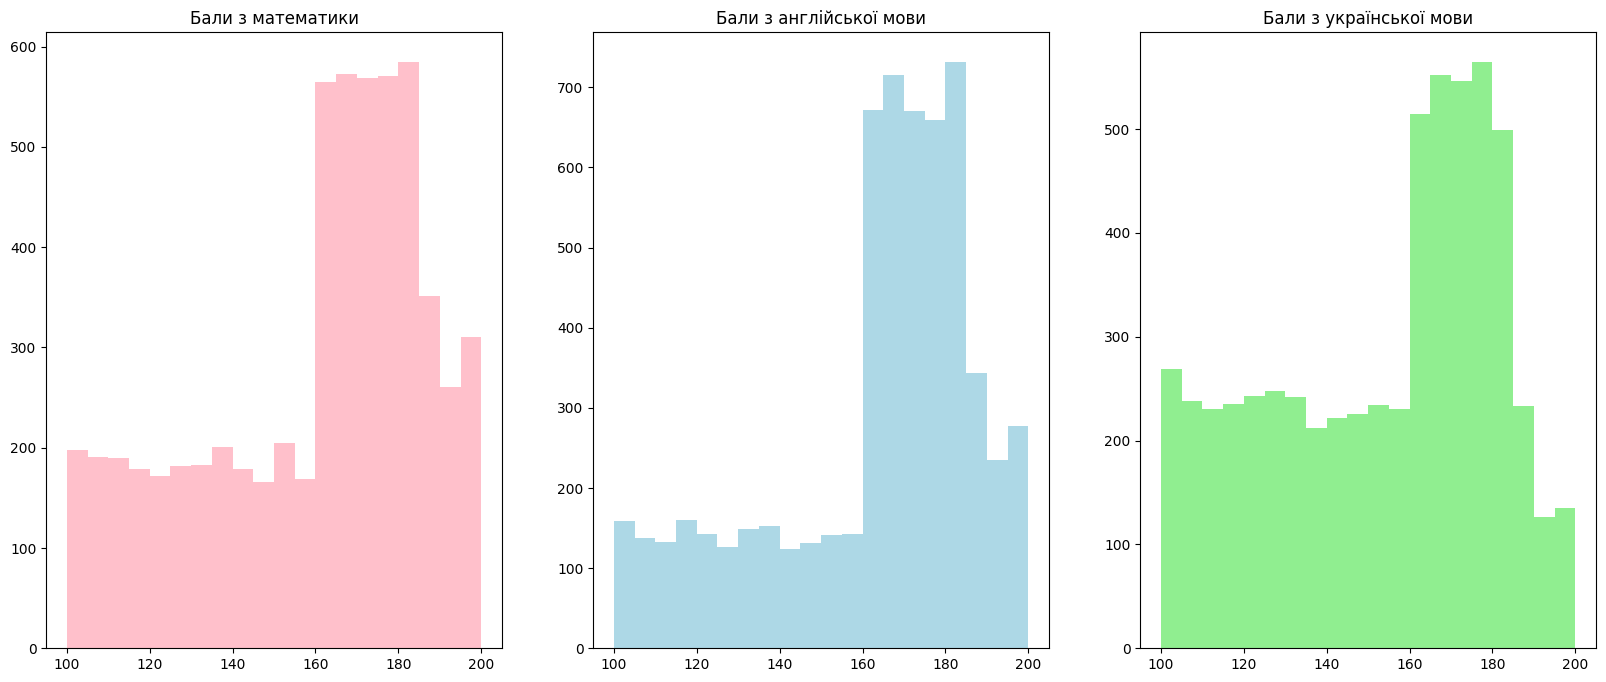

In [326]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
colors = ['pink', 'lightblue', 'lightgreen', 'yellow']

axs[0].set_title('Бали з математики')
axs[0].hist(applicant_data['M_score'], color=colors[0], bins=20)

axs[1].set_title('Бали з англійської мови')
axs[1].hist(applicant_data['E_score'], color=colors[1], bins=20)

axs[2].set_title('Бали з української мови')
axs[2].hist(applicant_data['U_score'], color=colors[2], bins=20)

plt.show()

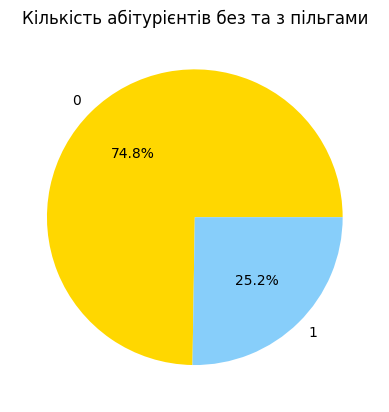

In [297]:
colors = ['gold', 'lightskyblue']

privilege_counts = applicant_data['privilege'].value_counts()
plt.pie(privilege_counts, labels=privilege_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Кількість абітурієнтів без та з пільгами')

plt.show()

In [ ]:
applicant_data.to_csv(r"C:\Users\5500\DataspellProjects\ML1\data\applicants.csv", index=True)

## Правила прийому

In [298]:
max_students = 350*years

In [299]:
work_df = applicant_data
work_df['rating'] = 0.4 * work_df['M_score'] + 0.3 * work_df['E_score'] + 0.3 * work_df['U_score']
work_df

,M_score,E_score,U_score,privilege,rating
0,193,110,103,0,141.1
1,109,167,168,0,144.1
2,187,170,172,1,177.4
3,154,162,175,0,162.7
4,156,163,130,1,150.3
...,...,...,...,...,...
5995,125,152,105,1,127.1
5996,186,150,173,1,171.3
5997,160,184,182,0,173.8
5998,190,160,195,0,182.5


In [300]:
def meeting_criteria(row):
    if row['privilege'] == 1:
        return int(row['M_score'] >= 120 and row['E_score'] >= 120 and row['U_score'] >= 120 and row['rating'] >= 145)
    else:
        return int(row['M_score'] >= 140 and row['rating'] >= 160)


In [301]:
work_df['met_criteria'] = work_df.apply(meeting_criteria, axis=1)
work_df

,M_score,E_score,U_score,privilege,rating,met_criteria
0,193,110,103,0,141.1,0
1,109,167,168,0,144.1,0
2,187,170,172,1,177.4,1
3,154,162,175,0,162.7,1
4,156,163,130,1,150.3,1
...,...,...,...,...,...,...
5995,125,152,105,1,127.1,0
5996,186,150,173,1,171.3,1
5997,160,184,182,0,173.8,1
5998,190,160,195,0,182.5,1


In [302]:
num_accepted = work_df['met_criteria'].sum()
print("Кількість абітурієнтів, що підходять за критеріями:", num_accepted)

Кількість абітурієнтів, що підходять за критеріями: 3115


In [303]:
work_df.loc[work_df['rating'][(work_df['privilege'] == 1) & (work_df['met_criteria'] == 1)].nlargest(round(max_students*0.1)).index, 'accepted'] = 1

In [304]:
work_df['accepted'].fillna(0, inplace=True)
work_df['accepted'] = work_df['accepted'].astype(int)

C:\Users\5500\AppData\Local\Temp\ipykernel_35484\1061422227.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  work_df['accepted'].fillna(0, inplace=True)


In [305]:
work_df.loc[work_df['rating'][(work_df['accepted'] == 0) & (work_df['met_criteria'] == 1)].nlargest(round(max_students*0.9)).index, 'accepted'] = 1
work_df

,M_score,E_score,U_score,privilege,rating,met_criteria,accepted
0,193,110,103,0,141.1,0,0
1,109,167,168,0,144.1,0,0
2,187,170,172,1,177.4,1,1
3,154,162,175,0,162.7,1,0
4,156,163,130,1,150.3,1,0
...,...,...,...,...,...,...,...
5995,125,152,105,1,127.1,0,0
5996,186,150,173,1,171.3,1,1
5997,160,184,182,0,173.8,1,1
5998,190,160,195,0,182.5,1,1


In [327]:
num_accepted = work_df['accepted'].sum()
print("Кількість абітурієнтів, що прийнято:", num_accepted)

Кількість абітурієнтів, що прийнято: 1400


## Створення мережі

In [306]:
x = work_df.drop(columns=['accepted', 'rating', 'met_criteria'], axis=1)
y = work_df['accepted']

In [307]:
scaler = MinMaxScaler(feature_range=(0,1))
x = scaler.fit_transform(x)
x

array([[0.93, 0.1 , 0.03, 0.  ],
       [0.09, 0.67, 0.68, 0.  ],
       [0.87, 0.7 , 0.72, 1.  ],
       ...,
       [0.6 , 0.84, 0.82, 0.  ],
       [0.9 , 0.6 , 0.95, 0.  ],
       [0.8 , 0.84, 0.58, 0.  ]])

In [308]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [309]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [310]:
input_size = (x_train.shape[1], )
network = Sequential()

network.add(Input(shape=input_size))
network.add(Dense(256, activation='relu'))
network.add(Dense(32, activation='relu'))
network.add(Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [311]:
network.fit(x_train, y_train, epochs=5, batch_size=128, verbose=1)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7187 - loss: 0.6192
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.4839
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8138 - loss: 0.3774
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9143 - loss: 0.2800
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9505 - loss: 0.2162


In [312]:
test_loss, test_acc = network.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.2153  


In [313]:
work_df['predicted'] = network.predict(scaler.fit_transform(work_df.drop(columns=['accepted', 'rating', 'met_criteria'], axis=1)))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [314]:
work_df

,M_score,E_score,U_score,privilege,rating,met_criteria,accepted,predicted
0,193,110,103,0,141.1,0,0,0.003430
1,109,167,168,0,144.1,0,0,0.011677
2,187,170,172,1,177.4,1,1,0.846716
3,154,162,175,0,162.7,1,0,0.373333
4,156,163,130,1,150.3,1,0,0.041834
...,...,...,...,...,...,...,...,...
5995,125,152,105,1,127.1,0,0,0.000685
5996,186,150,173,1,171.3,1,1,0.660540
5997,160,184,182,0,173.8,1,1,0.675925
5998,190,160,195,0,182.5,1,1,0.820151


## Використання моделі

In [315]:
new_applicants = pd.DataFrame({'M_score': generate_scores(1500),
                               'E_score':generate_scores(1500),
                               'U_score':generate_scores(1500),
                               'privilege':generate_privilege(1500)})
new_applicants.head()

,M_score,E_score,U_score,privilege
0,148,176,177,0
1,142,164,164,0
2,139,156,114,0
3,172,152,189,1
4,162,192,114,0


In [316]:
predictions = network.predict(scaler.fit_transform(new_applicants))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


In [317]:
new_applicants['accepted'] = predictions

In [318]:
new_applicants.drop(new_applicants.loc[new_applicants['accepted'] < 0.5].index, inplace=True)
new_applicants.drop(columns=['accepted'], axis=1, inplace=True)
new_applicants.reset_index(drop=True, inplace=True)

## Запис результатів

In [319]:
sheet_id = "1q4lhKK7a_zuRajAV5FaEQSNwNVH_Cu0kivLbZnS3a7s"
scopes = ['https://www.googleapis.com/auth/spreadsheets']

In [320]:
creds = Credentials.from_service_account_file("credentials.json", scopes=scopes)

In [321]:
client = gspread.authorize(creds)

In [322]:
sheet = client.open_by_key(sheet_id)

In [325]:
sheet.values_clear("'accepted'!A2:J10000")

{'spreadsheetId': '1q4lhKK7a_zuRajAV5FaEQSNwNVH_Cu0kivLbZnS3a7s',
 'clearedRange': 'accepted!A2:J1000'}

In [328]:
sheet.sheet1.update(new_applicants.values.tolist(), f"A2:D{new_applicants.shape[0]+1}")

{'spreadsheetId': '1q4lhKK7a_zuRajAV5FaEQSNwNVH_Cu0kivLbZnS3a7s',
 'updatedRange': 'accepted!A2:D475',
 'updatedRows': 474,
 'updatedColumns': 4,
 'updatedCells': 1896}